<a href="https://colab.research.google.com/github/transponster27/CS6271-UL2024/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP Multiple runs on an arbitrary Symbolic Regression Problem.

To make our code truly general, it is important to be able to read data in from a file and perform Symbolic Regression on it.

One big step up from previous notebooks is that we need to store our data somewhere that the notebook can get at.

Install DEAP.

In [ ]:
!pip install deap

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Clone the data folder from the class git repository and create a local copy for us to read. First, we need to create some space. You will be asked for confirmation by Google to do this.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone the data from the repository. Note that we can't clone **just** a folder, so we're actually bringing everything down.

In [ ]:
!git clone https://github.com/conorlime/CS6271

Cloning into 'CS6271'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 227 (delta 83), reused 183 (delta 70), pack-reused 21 (from 1)
Receiving objects: 100% (227/227), 3.90 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (84/84), done.


We can navigate through our drive here using standard Unix commands.

In [ ]:
pwd

'/content/CS6271/data/CS6271/data/CS6271/data'

In [ ]:
ls

conor01.csv  CS6271/  kotanchek_2d.csv  randomData.csv  sample.csv  spambase.csv


In [ ]:
cd CS6271/

/content/CS6271/data/CS6271/data/CS6271/data/CS6271


In [ ]:
ls

 CS6271_EvolutionaryAlgorithmsProject_2022.ipynb
 data/
'DEAP Algorithms (GA).ipynb'
'DEAP Algorithms (GA with multiple runs).ipynb'
'DEAP Algorithms (GP Parity).ipynb'
'DEAP Algorithms (GP Parity)- Reduced Function Set.ipynb'
'DEAP Algorithms (GP Symbolic Regression).ipynb'
'GA OneMax.ipynb'
'GA With Real Values.ipynb'
'GE_Applied_to_Classification_(Single_Type).ipynb'
 GE_Applied_to_Parity_Problems.ipynb
 GE_Classification_Problems_Multitype.ipynb
'GP Applied to classification (multiple runs + elitism).ipynb'
'GP Multiple runs on an arbitrary Symbolic Regression Problem.ipynb'
'GP Multiple runs on an arbitrary Symbolic Regression Problem With Elitism.ipynb'
'GP with multiple runs (even-parity problem).ipynb'
'GP With NSGA II.ipynb'
 README.md
 Utilities/


In [ ]:
cd data

/content/CS6271/data/CS6271/data/CS6271/data/CS6271/data


In [ ]:
ls

conor01.csv  kotanchek_2d.csv  randomData.csv  sample.csv  spambase.csv


Import our tools.

In [ ]:
import operator
import math
import random

import numpy
import pandas as pd

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv



import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters, one of which is now the number of runs.

In [ ]:
# Genetic Programming constants:
POPULATION_SIZE = 200
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10

N_RUNS = 30

Set the random seed.

In [ ]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [ ]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Read in the data.

In [ ]:
!pip install python-docx

In [ ]:
import pandas as pd

z_train = pd.read_csv("/content/salustowicz_input_file.csv")
z_train.head()

,Z1,TARGET
0,0.05,-0.000006
1,0.35,-0.008657
2,0.65,-0.048932
3,0.95,-0.096507
4,1.25,-0.119897


Define our fitness function.

In [ ]:
def evalSymbReg(individual):
    ERROR_CEIL = 1000        #max error

    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual) # type: ignore
    # Evaluate the mean squared error between the expression
    # and the real function : f(z) = e^{-z}z^{3}cos(z)sin(z)\left[cos(z)sin^{2}(z)-1\right]
    try:
        mse = 0.0
        for i in range(len(z_train)):
            z = z_train["Z1"][i]
            y = z_train["TARGET"][i]
            mse += ((func(z) - y) ** 2) / len(z_train)
            # if error exceeds ciel, cap at 1000
            if mse > ERROR_CEIL:
                mse = ERROR_CEIL
    except OverflowError:
        mse = ERROR_CEIL

    if math.isnan(mse):    # handle NaN's
        mse = ERROR_CEIL

    nodes, _, _ = gp.graph(individual)
    return mse, len(nodes)

Define a protected division function.

In [ ]:
# Protected functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1


def psin(n):
    try:
        return numpy.sin(n)
    except Exception:
        return numpy.nan

def pcos(n):
    try:
        return numpy.cos(n)
    except Exception:
        return numpy.nan

def pow2(n):
    return operator.pow(n, 2)

Add our functions and terminals.

In [ ]:
pset = gp.PrimitiveSet("MAIN", 1) # input = Z1

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)

pset.addPrimitive(pow2, 1)
pset.addPrimitive(psin, 1)
pset.addPrimitive(pcos, 1)

pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(math.cos, 1)
#pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.random())


/usr/local/lib/python3.10/dist-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Create our toolbox.

In [ ]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg)
#toolbox.register("select", tools.selNSGA2)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Create our statistics. These are a bit more complex than the GA ones because we want to keep track of fitness and size for all runs.

In [ ]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

Now the magic happens and we run **N_RUNS** times. Always start with a small number of runs and generations to make sure that everything is working properly before you commit to a larger number. That way, if something goes horribly wrong, Python won't replicate it 30 times before giving you back control!

In [ ]:
for r in range(0, N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


    # Create our statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)


    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)


    # It's usually a good idea to turn off verbose when conducting multiple runs
    population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=False)

    #maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
    meanFitnessValues, stdFitnessValues, minFitnessValues, maxFitnessValues  = logbook.chapters['fitness'].select("avg", "std", "min", "max")
    meanSizeValues, stdSizeValues, minSizeValues, maxSizeValues  = logbook.chapters['size'].select("avg", "std", "min", "max")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    stdListFitness.append(stdFitnessValues)
    minListFitness.append(minFitnessValues)
    maxListFitness.append(maxFitnessValues)

    avgListSize.append(meanSizeValues)
    stdListSize.append(stdSizeValues)
    minListSize.append(minSizeValues)
    maxListSize.append(maxSizeValues)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])





Currently on run 0 of 30


<ipython-input-99-a1ac6c54e9bb>:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right
<ipython-input-99-a1ac6c54e9bb>:11: RuntimeWarning: invalid value encountered in sin
  return numpy.sin(n)


-- Best Individual =  mul(psin(pcos(protectedDiv(ARG0, 0.41058210807438045))), 0.11725223921802852)
-- length=7, height=4
-- Best Fitness =  0.0818848585015437


Currently on run 1 of 30
-- Best Individual =  mul(0.19661418898326988, psin(sub(add(pcos(neg(add(0.894865336964506, ARG0))), psin(add(neg(ARG0), psin(ARG0)))), sub(sub(mul(add(0.6212992659660864, ARG0), pcos(0.2660496319088371)), pcos(psin(psin(psin(psin(ARG0)))))), mul(protectedDiv(mul(ARG0, 0.4598000860909818), ARG0), neg(psin(ARG0)))))))
-- length=39, height=10
-- Best Fitness =  0.06251167187073076


Currently on run 2 of 30
-- Best Individual =  mul(psin(add(add(add(add(psin(psin(add(psin(psin(psin(ARG0))), psin(add(psin(psin(ARG0)), add(psin(ARG0), psin(ARG0))))))), psin(add(ARG0, ARG0))), psin(psin(psin(add(psin(add(psin(psin(add(ARG0, psin(psin(ARG0))))), ARG0)), psin(ARG0)))))), psin(add(psin(ARG0), ARG0))), psin(add(add(psin(psin(ARG0)), psin(psin(psin(ARG0)))), psin(psin(psin(psin(ARG0)))))))), 0.14597013816602855)

<ipython-input-99-a1ac6c54e9bb>:17: RuntimeWarning: invalid value encountered in cos
  return numpy.cos(n)


-- Best Individual =  mul(psin(ARG0), psin(neg(sub(pcos(ARG0), sub(ARG0, ARG0)))))
-- length=11, height=5
-- Best Fitness =  0.05585825876774062


Currently on run 4 of 30
-- Best Individual =  mul(sub(psin(sub(pow2(pcos(neg(0.33323737695234246))), protectedDiv(psin(ARG0), pcos(ARG0)))), psin(sub(psin(ARG0), ARG0))), 0.1337845392508904)
-- length=19, height=7
-- Best Fitness =  0.06370353200170277


Currently on run 5 of 30
-- Best Individual =  psin(mul(pow2(0.20928876971386745), 0.2717515614529996))
-- length=5, height=3
-- Best Fitness =  0.10126252209795583


Currently on run 6 of 30
-- Best Individual =  protectedDiv(psin(ARG0), add(0.8888939152470683, ARG0))
-- length=6, height=2
-- Best Fitness =  0.10108948353261077


Currently on run 7 of 30
-- Best Individual =  mul(0.2236020288374091, psin(psin(psin(psin(ARG0)))))
-- length=7, height=5
-- Best Fitness =  0.08829011416905151


Currently on run 8 of 30
-- Best Individual =  mul(mul(psin(sub(ARG0, psin(ARG0))), 0.05957031990054

<ipython-input-99-a1ac6c54e9bb>:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right


-- Best Individual =  mul(psin(psin(psin(psin(psin(psin(psin(ARG0))))))), psin(neg(pcos(ARG0))))
-- length=13, height=8
-- Best Fitness =  0.04929456628629199


Currently on run 17 of 30
-- Best Individual =  mul(psin(neg(ARG0)), pcos(neg(ARG0)))
-- length=7, height=3
-- Best Fitness =  0.06210142711427541


Currently on run 18 of 30
-- Best Individual =  mul(0.08461477960284536, 0.14757290050449423)
-- length=3, height=1
-- Best Fitness =  0.10126220377439718


Currently on run 19 of 30
-- Best Individual =  mul(psin(mul(ARG0, psin(psin(psin(psin(psin(psin(psin(psin(psin(mul(ARG0, psin(psin(psin(psin(ARG0)))))))))))))))), 0.15057232691504474)
-- length=21, height=17
-- Best Fitness =  0.07071389456057998


Currently on run 20 of 30
-- Best Individual =  psin(mul(0.07985190754572857, pcos(mul(psin(ARG0), protectedDiv(ARG0, 0.9292859737655021)))))
-- length=10, height=5
-- Best Fitness =  0.10047752396811678


Currently on run 21 of 30
-- Best Individual =  mul(pcos(sub(add(pcos(mul(ARG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create our graphs using the averages across all the runs. Notice how we use standard deviation to show how much variation there is in the runs.

Notice that if there's a big discrepancy between best and average the graphs can look like there's virtually no variation in the best score. If this happens, the first thing to do is verify if that is actually happening; you can do that by commenting out this line:

**plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")**

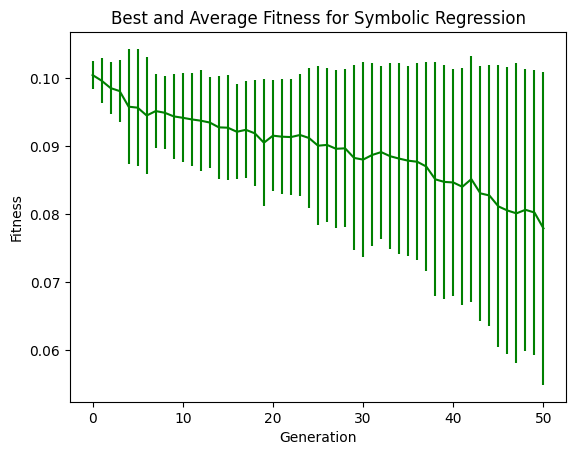

In [ ]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Symbolic Regression')
#plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()

Show the graph for size.

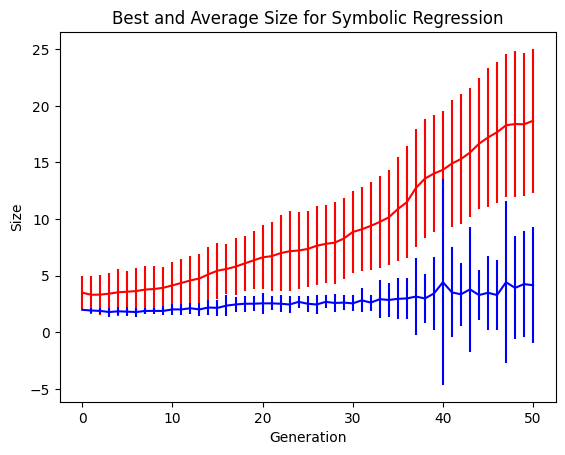

In [ ]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListSize)
stdArray = numpy.array(stdListSize)
minArray = numpy.array(minListSize)
maxArray = numpy.array(maxListSize)
plt.xlabel('Generation')
plt.ylabel('Size')
plt.title('Best and Average Size for Symbolic Regression')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Blue")
plt.show()

In [ ]:
y_actual = pd.read_csv("/content/salustowicz_test_dataset.csv")
y_actual.head()

,Z1,TARGET
0,-0.50,-0.069219
1,-0.45,-0.046438
2,-0.40,-0.029462
3,-0.35,-0.017433
4,-0.30,-0.009431


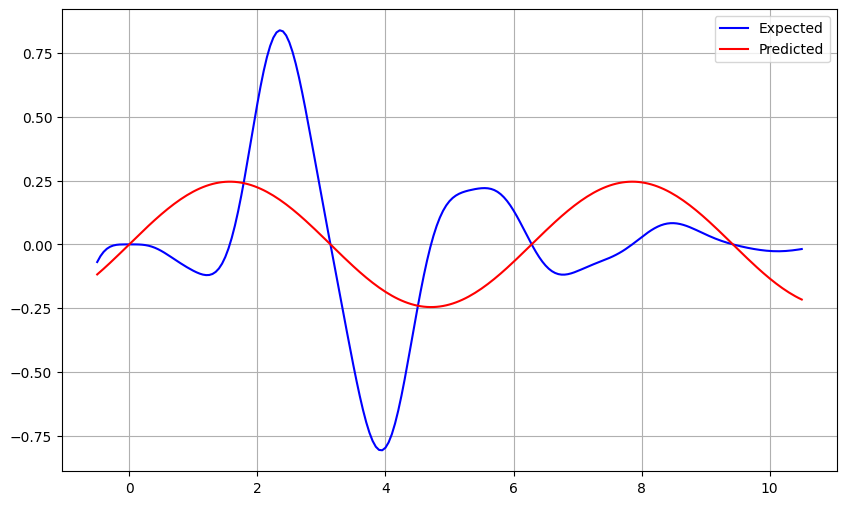

In [ ]:
# use your best individual so far to plot a graph with its outputs, and plot the expected curve (from the dataset) in the same graph.

func = toolbox.compile(expr=best)

z1Values = y_actual["Z1"].values
targetValues = y_actual["TARGET"].values

plt.figure(figsize=(10, 6))
plt.plot(z1Values, targetValues, label="Expected", color="blue")

predictedValues = [func(z) for z in z1Values]
plt.plot(z1Values, predictedValues, label="Predicted", color="red")

plt.legend()
plt.grid(True)